<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Read_Ultrasound_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2


!pip3 install -q torchinfo
!pip3 install -Uqq ipdb
################################################################################
#ULTRASOUND NEEDS
import PIL
#from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)
from matplotlib import image
from ast import literal_eval #used to break out bounding boxes from strings
import time
import torch
import torchvision
import torchinfo

from torchinfo import summary
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler



import torchinfo


import ipdb
################################################################################

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/Shareddrives/BreastUS'
local_dir = '/content/gdrive/My Drive/BreastUS' #for local storage


'''
top_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES' 
csv_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/'


#output patch save dir
patch_normal_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL'
patch_actionable_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/ACTIONABLE' 
patch_benign_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/BENIGN'
patch_cancer_dir = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER'
'''



### Enable GPU, if present
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-e94b80b6-9cee-1bd7-11e3-15d5aaad0e0d)
Fri Nov 26 09:20:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |       

In [2]:
#
# Get DICOM info
#
local_files = os.listdir(local_dir)

for dicom_file in local_files:
    filename = os.path.join(local_dir,dicom_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('dcm' in filename):
        print(filename)
        ds = dcmread(filename, force=True)
        for element in ds:
            print(element)

    else:
        print('Non-dicom file found ',filename)

/content/gdrive/My Drive/BreastUS/1.dcm
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'SMALL PARTS']
(0008, 0012) Instance Creation Date              DA: '20211111'
(0008, 0013) Instance Creation Time              TM: '132938'
(0008, 0016) SOP Class UID                       UI: Ultrasound Multi-frame Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113663.1500.1.365952523.3.2.20210204.132938.671
(0008, 0020) Study Date                          DA: '20211111'
(0008, 0021) Series Date                         DA: '20211111'
(0008, 0023) Content Date                        DA: '20211111'
(0008, 002a) Acquisition DateTime                DT: '20211111'
(0008, 0030) Study Time                          TM: '130201'
(0008, 0031) Series Time                         TM: '130201'
(0008, 0033) Content Time                        TM: '132938'
(0008, 0050) Accession Number       

In [3]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [4]:
#Load a dicom image and convert it using dcm_read to get view type (needs this 
#to correctly align image))

csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')
data_files = os.listdir(annotated_dir)


label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)



#sample_dicom = os.path.join(dicom_dir,dicom_files[0]) #for now, just use first

#!ls '/content/gdrive/Shareddrives/BreastUS'

# GET CSV INFO

In [5]:
#READ CSV FILES
#pull out the box information and label info
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('_final' in csv_file):
        annotation_fields, annotation_rows = get_csv_data(filename)

    else:
        print('Non-archive file found ',filename)

found rows: 8843
Non-archive file found  /content/gdrive/Shareddrives/BreastUS/Annotated data/annotations_updated.csv


#Sort data into fields

In [6]:


print(np.shape(annotation_rows))

print(annotation_fields)

array_rows = np.array(annotation_rows)
mrn = array_rows[:,1]
accession = array_rows[:,2]
video_id = array_rows[:,3]
frame_id = array_rows[:,4]
image_path = array_rows[:,5]
bounding_box = array_rows[:,6]
diagnosis = array_rows[:,7]
biopsy_site = array_rows[:,8]
diagnosis2 = array_rows[:,9]
first50 = array_rows[:,10]


(8842, 11)
['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']


# CROPPING IMAGES 

In [7]:
def crop_us_image(img, debug =0):
################################################################################
#
## Look for coordinates to cut the US data out of the image overlay
################################################################################


#
# Get valid rows for the embedded US image
#
    nrows, ncols = np.shape(img)
    middle_column = np.uint(ncols/2)
    middle_row = np.uint(nrows/2)

    #find the 0 gaps before and after the image on the column
    data_strip = img[:,middle_column]
    index = np.where(data_strip == 0) #find first section of 0 values
    first_row_gap = index[0][0]
    diff_row = np.diff(index)


    #find the large jump in diff, that will likely be US image then down to background 0
    #second_row_gap = np.where(diff_row >= 150)
    if (debug == 1):
        print('diff in func ',diff_row)

    leading_found = 0
    trailing_found = 0
    leading_row_edge=0
    for counter,ii in enumerate(diff_row[0]):
        case_status = 1 #assume case will be usable, if not change flag
        if ((counter > 2) and 
            (counter < (np.size(diff_row)-6) )):

            #find a set of diff 0s that skip a distance (edge)
            if ( (diff_row[0][counter-3] <5 ) and
                (diff_row[0][counter-2] <5) and
                (diff_row[0][counter-1] <5) and
                (ii> 10) and
                (leading_found ==0)):
                
                leading_row_edge = index[0][counter]
                leading_found = 1
                
                #print('**found a leading edge at counter, val, image row', counter,ii, leading_row_edge)
                continue
                 #only need first point
            '''
            if ( (diff_row[0][counter+3] ==1 ) and
                (diff_row[0][counter+2] ==1) and
                (diff_row[0][counter+1] ==1) and
                (ii>=2) and 
                (leading_found == 1)):
            '''
            if (leading_found ==1): #(counter > leading_row_edge):

                for jj in range(0,6):
                    if (diff_row[0][counter+jj] <=5):
                        numzero =1
                    else:
                        numzero = 0
                        break
                
                if (numzero == 1):
                    #print('finding trail at ',counter)
                    trailing_row_edge=index[0][counter]
                    trailing_found = 1 #fix this
                    #print('!!found a trail edge at counter, val, image row',
                    #    counter,ii, trailing_row_edge)
                    break
                 #only need first point



    try:
        low_row = leading_row_edge #index[0][second_row_gap[1][0]]
        high_row = trailing_row_edge #index[0][second_row_gap[1][0]+1] 
    except:
        print('could not find a second row for img')
        
        skip_points = [0,0,0,0]
        case_status = 0
        return img, skip_points, case_status #0 signifies this one failed, remove it
    #
    # Clip columns by finding rows with continuous 0 vals. Find the diff between 
    # elements and take the first point where the black transitions to a non-zero 
    # value. This is the first cutoff. The second is where the transition from 
    # regular data to zeros occurs
    #
    data_rows = img[(np.uint(nrows*0.25), np.uint(nrows*0.5), np.uint(nrows*0.75)),:]
    
    if (debug == 1):
        plt.figure()
        x=np.arange(0,ncols)
        plt.plot(x,data_rows[0,:],'r.-',x,data_rows[1,:], 'b.-',x,data_rows[2,:],'k.-')
        

    #top 75% row should be clear of all burned images at the beginning
    xx = np.ediff1d(data_rows[2,:])
    start= np.where(xx >00)

    
    if (not start): #empty list is FALSE
        case_status = 0
        skip_points = [0,0,0,0]
        print('Could not find enough column points, skipping')
        return img, skip_points, case_status #0 signifies this one failed, remove it

    try:
        start_column = start[0][0] +1 #since it's a diff, add one pixel
        final_column = start[0][-1] -1 #last point where diff >0
    except:
        print('Failed to get a "where" point. Skipping')
        case_status = 0
        skip_points = [0,0,0,0]
        return img, skip_points, case_status #0 signifies this one failed, remove it

    '''
    print(start[0])
    plt.figure()
    plt.imshow(img[low_row:high_row,start_column:final_column],cmap='gray')
    plt.title('cropped')
    '''

    #print('inside cropping, shape is ', np.shape(img))
    skip_points = [low_row, high_row,start_column, final_column]
    return img[low_row:high_row,start_column:final_column], skip_points, case_status

In [8]:
if(0):
    num_mrn = set(mrn)
    num_mrn
    image_path[0:3]

    print(image_path[0])
    filename = os.path.basename(image_path[0]) 
    [_,fpath] =image_path[0].split('drive/MyDrive/Annotated data/')
    full_file = os.path.join(annotated_dir,fpath)
    print(full_file)

    print('filename exists: ',os.path.exists(full_file))
    import imageio

    #import PIL
    #from PIL import Image
    # Open the image form working directory
    #image = Image.open(full_file)

    #from matplotlib import image
    #from matplotlib import pyplot
    img = image.imread(full_file)



    ## Convert the RGB input into grayscale
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray, cmap='gray')
    plt.show()

    cropped_image,skip_points,case_status = crop_us_image(imgGray,0)
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(cropped_image, cmap='gray')
    plt.title('cropped image')


In [9]:
if(0):
    #del cropped_image,  img_data
    img_data = image.imread(idata)
    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    print('shape of imgGray is ', np.shape(imgGray))
    cropped_image, _ = crop_us_image(imgGray,0)
    if (np.size(cropped_image) <1):
        print('Failure during cropping for ', file_name)
    print('shape is ', np.shape(cropped_image))
    plt.figure()
    plt.imshow(cropped_image)

    cropped_image = cv2.resize(cropped_image, dsize=(480, 600),
                                interpolation=cv2.INTER_CUBIC)

### SAVE IMAGES TO DISK

In [10]:
if(0):
    #['', 'coded_mrn', 'coded_accession', 'video_id', 'frame_id', 'image_path', 'bounding box', 'Final Diagnosis', 'Bx Site', 'Final Diagnosis.1', 'First 50']
    '''
    mrn = array_rows[:,1]
    accession = array_rows[:,2]
    video_id = array_rows[:,3]
    frame_id = array_rows[:,4]
    image_path = array_rows[:,5]
    bounding_box = array_rows[:,6]
    diagnosis = array_rows[:,7]
    biopsy_site = array_rows[:,8]
    diagnosis2 = array_rows[:,9]
    first50 = array_rows[:,10]
    '''

    mrn_list = set(mrn)

    acc =set()
    vid = set()

    #try first US video in first mrn


    for count,mm in enumerate(mrn):
        
        if mm in mrn[0]:
            acc.add(accession[count])
            vid.add(video_id[count])

    screen_dir = '/content/gdrive/My Drive/BreastUS/SCREEN_CAPS/'
    #video_save = os.path.join()


    file_name =[]
    vname=[]
    boundary_box = []
    for cc,video_temp in enumerate(video_id):
        [_,fpath] =image_path[cc].split('drive/MyDrive/Annotated data/')
        full_file = os.path.join(annotated_dir,fpath)
        file_name.append(full_file)
        vname.append(video_temp)
        boundary_box.append(bounding_box[cc])

    print(file_name[0])
    print(vname[0])
    print(len(file_name))


    case_holder = []
    failed_list = [] #record of images that failed cropping

    skip_to = 8002 #-1
    for count,ii in enumerate(file_name):

        if (count < skip_to):
            continue #skip these until we get back to the proper file

        #
        # Save folder information. Get the video name and make a folder with that 
        # long name in the screen caps folder
        #
        video_save = os.path.join(screen_dir,vname[count])
        if(os.path.exists(video_save)):
            print('folder found')
        else:
            os.mkdir(video_save)

        img_data = image.imread(ii)
        #print(np.shape(img_data))
        #print('Processing: ', ii)
        print(count)


        corners=literal_eval(boundary_box[count]) #bounding_box[count])
        #bounding box values are in (x,y) formats from xml
        #print('corners, len = ',corners, len(corners))
        #print('bounding box = ',boundary_box[count]) #bounding_box[count])

        '''
        Bounding box ordering is 
        point 1        point 2
        ----------------------
        point 4        point 3
        '''
        if (len(corners)>0):
            #print('corners ',pos)
            pos = np.uint(corners)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            #boxes.append([xmin, ymin, xmax, ymax])
            h=ymax-ymin
            w=xmax-xmin
        else:
            #print('EMPTY bounding box')
            xmin=np.uint(1)
            xmax=np.uint(2)
            ymin=np.uint(1)
            ymax=np.uint(2)
            h=0
            w=0
            #boxes.append([xmin, ymin, xmax, ymax])



        #skip points =[low_row, high_row,start_column, final_column]
        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B


        #
        # Crop the image to the Ultrasound borders. If it fails during this 
        # process, mark it and continue to next image. That failed index will be
        # stored to remove any failed images later
        #
        cropped_image, skip_points,fail_flag = crop_us_image(imgGray,0)


        show_plots = 0
        if (fail_flag == 1): #if cropping worked, process annotations

            #print('skip points = ',skip_points)
            #print('h = ymax-ymin',ymax,ymin,h)
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]

            if (len(corners)>0):
                width = xmax-xmin
                height = ymax-ymin
                rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
                #print('adding rectangle ',offset_row, offset_col, height, width)
                #print(ymin, ymax, xmin, xmax)
            else:
                rect = patches.Rectangle((0,0),0,0,linewidth=1,edgecolor='r',facecolor='none')

            if (show_plots == 1):
                show_crop = 0
                if (show_crop == 0):

                    fig = plt.figure(figsize=(8, 6), dpi=80)
                    #plt.figure(figsize=(8, 6), dpi=80)
                    #plt.imshow(cropped_image, cmap='gray')
                    plt.imshow(cropped_image,cmap='gray')
                    # Get the current reference
                    ax = plt.gca()
                    # Add the patch to the Axes
                    ax.add_patch(rect)

                    fname = os.path.join(video_save,os.path.basename(ii))
                    #fname = os.path.basename(ii)
                    title_text = 'Frame ' + str(fname)
                    plt.title(title_text)
                    
                    plt.savefig(os.path.join(screen_dir,str(fname)))
                    #time.sleep(1)
                    #plt.show()
                    plt.close()


                if (show_crop == 1):  
                    if (len(corners)>0):
                        plt.figure(figsize=(8, 6), dpi=80)
                        plt.imshow(img_data,cmap='gray')
                
                    # Get the current reference
                        
                        rect = patches.Rectangle((corners[0][0],corners[0][1]),w,h,linewidth=1,edgecolor='r',facecolor='none')
                        bx = plt.gca()
                        # Add the patch to the Axes
                        bx.add_patch(rect)
                        plt.show()
                        plt.close()

        else:
            print('Failed crop for : ',file_name)
            failed_list.append(count)
        #save the fail list and file name list to remove fails later
        if (count%1000 == 0):
            status_file = os.path.join(local_dir,'us_status_index2nd.pickle')

            pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )


    print('finished plotting all images')


    status_file = os.path.join(local_dir,'us_status_index2nd.pickle')
    pickle.dump([failed_list],open( status_file, "wb" ),protocol=5 )

        



    #print('filename exists: ',os.path.exists(full_file))

    #image = image.imread(full_file)
    #print(np.shape(image))


In [11]:
if(0):
    status_file = os.path.join(local_dir,'Copy of us_status_index.pickle')
    f1 = pickle.load( open( status_file, "rb" ) )

    print(len(f1[0]))



    status_file = os.path.join(local_dir,'us_status_index2nd.pickle')
    f2 = pickle.load( open( status_file, "rb" ) )

    print(len(f2[0]))

    bad_count = f1[0]+f2[0]
    print(len(bad_count))

    bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
    pickle.dump([bad_count],open( bad_files, "wb" ),protocol=5 )

In [12]:
if(0):
    #Test out problem images
    #idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000036.PNG'
    idata = file_name[8002]
    img_data = image.imread(idata)
    print(np.shape(img_data))

    %pdb off


    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray,cmap='gray')

    cropped_image, skip_points,fail_flag = crop_us_image(imgGray,1)

In [13]:
if(0):
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_2w948u10_a_06g91d42_4.mp4-2021_08_20_17_24_25-labelme 3.0.zip/default/frame_000159.PNG'
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000036.PNG'

    img_data = image.imread(idata)
    print(np.shape(img_data))


    ## Convert the RGB input into grayscale
    R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(imgGray,cmap='gray')




    nrows, ncols = np.shape(imgGray)
    middle_column = np.uint(ncols/2)
    middle_row = np.uint(nrows/2)

    #find the 0 gaps before and after the image on the column
    data_strip = imgGray[:,middle_column]
    index = np.where(data_strip == 0) #find first section of 0 values
    print('shape of index= ',np.shape(index))
    print('shape of data strip = ',np.shape(data_strip))
    print('data_strip 0:20 ',data_strip[0:20])
    print('index 0:20 ', index[0][:])


    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(data_strip)
    plt.ylabel('intensity')
    plt.xlabel('rows')
    ttext = 'Strip Slice at column ' +  str(middle_column)
    plt.title(ttext)

    plt.figure()
    plt.plot(data_strip[400:500])
    plt.title('zoomed')



    first_row_gap = index[0][0]
    diff_row = np.diff(index[0])

    print('diff ' , diff_row)

    for counter,ii in enumerate(diff_row):
        if (counter > 2):
            #find a set of diff 0s that skip a distance (edge)
            if ( (diff_row[counter-3] <5 ) and
                (diff_row[counter-2] <5) and
                (diff_row[counter-1] <5) and
                (ii> 50)):
                print('found an edge at ', counter,ii, index[0][counter])
                second_row_gap = index[0][counter]
                break #only need first point

    #find the large jump in diff, that will likely be US image then down to background 0
    #second_row_gap = np.where(diff_row >= 150)





    print('Second Row Gap ',second_row_gap)
    plt.figure()
    plt.plot(data_strip,'r.-')



    cropped_image, skip_points = crop_us_image(imgGray,1)
    plt.figure()
    plt.imshow(cropped_image,cmap='gray')


In [14]:
### test code
if(0):
    '''
    DOES NOT WORK!!!!!!!!!!!!!!!!!!!!!!!!!!!
    '''
    import cv2
    from google.colab.patches import cv2_imshow
    idata = '/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_2w948u10_a_06g91d42_4.mp4-2021_08_20_17_24_25-labelme 3.0.zip/default/frame_000159.PNG'

    import cv2

    # Load the image
    img = cv2.imread(idata)

    # convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    edged = cv2.Canny(img, 170, 490)
    # Apply adaptive threshold
    thresh = cv2.adaptiveThreshold(edged, 1, 1, 1, 11, 2)
    thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

    # apply some dilation and erosion to join the gaps - change iteration to detect more or less area's
    thresh = cv2.dilate(thresh,None,iterations = 15)
    thresh = cv2.erode(thresh,None,iterations = 15)

    # Find the contours
    contours,hierarchy = cv2.findContours(thresh,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, find the bounding rectangle and draw it
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img,
                        (x,y),(x+w,y+h),
                        (0,255,0),
                        2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [15]:
if(0):
    #
    # Test images as 3d volumes
    #
    for counter, ii in enumerate(file_name):
        img_data = image.imread(ii)
        print(np.shape(img_data))
        if (counter >0):
            break



        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        cropped_image = crop_us_image(imgGray)
        



        #img = cv2.imread('your_image.jpg')
        cropped_image = cv2.resize(cropped_image, dsize=(600, 480), interpolation=cv2.INTER_CUBIC)

        nr,nc = np.shape(cropped_image)
        img_volume = np.zeros((3,480,600)) #nr,nc))
        img_volume[0,:,:] = cropped_image
        img_volume[1,:,:] = cropped_image
        img_volume[2,:,:] = cropped_image
        
        
        plt.figure(figsize=(8, 6), dpi=80)
        plt.imshow(img_volume[0,:,:], cmap='gray')


# Bounding Box information

In [16]:
#
# Bounding box info
#
import torch
print('-------')
uvids = set(video_id)

for v in uvids:
    for count,ii in enumerate(video_id):
        if (v in ii):
            #get bb info
            box_info = bounding_box[count]
            #box_info = box_info.strip('][') #.split(', ')

            if (not (box_info =='[]')):
                
                corners=literal_eval(box_info)
                bbox = torch.FloatTensor(corners)
                #print(corners)
            else:
                continue
            

-------


In [17]:
def get_bb_stats(bounding_box):
    total_area=[]
    num_box=0
    num_h=[]
    num_w=[]
    for index in range(0,len(bounding_box)):

        corners=literal_eval(bounding_box[index])

        boxes = []
        area = 0
        pos=literal_eval(bounding_box[index])

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):
            #print('corners ',pos)
            pos = np.int32(pos)
            xmin = pos[0][1]
            xmax = pos[2][1]
            ymin = pos[0][0]
            ymax = pos[1][0]
            w=xmax-xmin
            h = ymax-ymin
            num_h.append(h)
            num_w.append(w)
            boxes.append([xmin, ymin, xmax, ymax])
            area += (xmax-xmin)*(ymax-ymin)
            total_area.append(area)
            num_box+=1
    return total_area, num_box,num_h, num_w

57268.8385847562
171.43091005104736
smallest width is  55
largest width is   359
276.0306284104911
smallest height is  47
largest height is   574
----- [124.   0.   0.  66.  26. 120. 143. 317. 183. 288. 186. 369. 109. 232.
 268. 232. 161. 180.   0.  48.  29. 207.  89. 115.   6. 280.  92.  29.
  81.   1.   2.  87. 232. 168.   9. 164.  56.  82.  50.   0. 125.  85.
 104.   0. 178.   0.  68. 161.  55.  74.]
max Height bin is  0 317.0
max Height bin is  1 369.0
max Height bin is  2 280.0
max Height bin is  3 232.0
max Height bin is  4 178.0
----- [176.   0. 212.  98.  39. 245. 178. 116. 281. 137. 250. 157. 102. 180.
 347. 296. 432. 309.  91.   4.   0.  88. 169.  81.   0. 220. 202. 163.
   0.  88.  87.  60.   0.   0.   0.   0.   0.   0.   0.   0. 125. 233.
  85.  91.   0.  83.   0. 178.   0.  78.]
max Width bin is  0 281.0
max Width bin is  1 432.0
max Width bin is  2 220.0
max Width bin is  3 87.0
max Width bin is  4 233.0


(array([176.,   0., 212.,  98.,  39., 245., 178., 116., 281., 137., 250.,
        157., 102., 180., 347., 296., 432., 309.,  91.,   4.,   0.,  88.,
        169.,  81.,   0., 220., 202., 163.,   0.,  88.,  87.,  60.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 125., 233.,  85.,  91.,
          0.,  83.,   0., 178.,   0.,  78.]),
 array([ 55.  ,  61.08,  67.16,  73.24,  79.32,  85.4 ,  91.48,  97.56,
        103.64, 109.72, 115.8 , 121.88, 127.96, 134.04, 140.12, 146.2 ,
        152.28, 158.36, 164.44, 170.52, 176.6 , 182.68, 188.76, 194.84,
        200.92, 207.  , 213.08, 219.16, 225.24, 231.32, 237.4 , 243.48,
        249.56, 255.64, 261.72, 267.8 , 273.88, 279.96, 286.04, 292.12,
        298.2 , 304.28, 310.36, 316.44, 322.52, 328.6 , 334.68, 340.76,
        346.84, 352.92, 359.  ]),
 <a list of 50 Patch objects>)

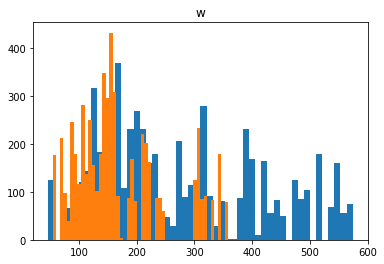

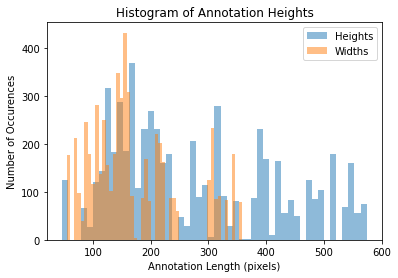

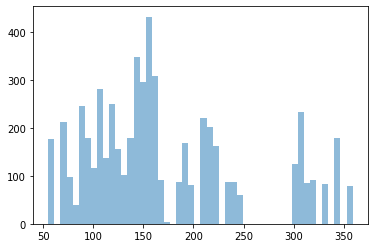

In [18]:
#bounding_box
ta,box_num,num_h, num_w=get_bb_stats(bounding_box)

avg_area = sum(ta)/len(ta)
print(avg_area)

#avg width
print(np.average(num_w))
#get smallest box

print('smallest width is ', np.min(num_w))
print('largest width is  ', np.max(num_w))

#avg height
print(np.average(num_h))
print('smallest height is ', np.min(num_h))
print('largest height is  ',np.max(num_h))

vv,_,_=plt.hist(num_h, bins = 50)
plt.title('h')
print('-----',vv)

for ii in range(0,5):
    bin_max = np.max(vv[ii*10:ii*10+9])
    print('max Height bin is ', ii,bin_max)

vv,_,_=plt.hist(num_w, bins = 50)
plt.title('w')
print('-----',vv)

for ii in range(0,5):
    bin_max = np.max(vv[ii*10:ii*10+9])
    print('max Width bin is ', ii,bin_max)




plt.figure()
plt.hist(num_h, bins=50,alpha=0.5, label="Heights")
plt.hist(num_w,bins=50,alpha=0.5, label="Widths")
plt.title('Histogram of Annotation Heights')
plt.ylabel('Number of Occurences')
plt.xlabel('Annotation Length (pixels)')
plt.legend(loc='upper right')

plt.figure()
plt.hist(num_w,bins=50,alpha=0.5, label="Widths")


In [19]:
#generate stats on bounding boxes
uvids = set(video_id)

box_collect=[]
frames_collect=[]
empty_annotations=[]
for count, v in enumerate(uvids):
    number_frames = 0
    number_boxes = 0
    
    #print('---- loading: ', v)
    for icount,ii in enumerate(video_id):
        if (ii == v):
            box_info = bounding_box[icount]
            number_frames+=1
            if (not (box_info =='[]')):
                number_boxes+=1
            else:
                pass
                #print('no annotation', frame_id[icount])
    frames_collect.append(number_frames)
    box_collect.append(number_boxes)
    #print(v,number_frames,number_boxes)
    if (number_boxes == 0):
        empty_annotations.append(v)




print('Number of videos: ',np.size(frames_collect[:]))
print('Number of annotated cases ',np.size(box_collect))
print('Videos with no Annotations:', empty_annotations)
    #get_bb_stats(v, video_id,bounding_box, image_path)


Number of videos:  102
Number of annotated cases  102
Videos with no Annotations: ['1_jq3lf35n_a_12h3r1u8_2.mp4-2021_07_15_17_21_26-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_0.mp4-2021_07_15_17_21_32-labelme 3.0.zip', '1_en9w0q3l_a_e128787p_2.mp4-2021_09_22_21_42_11-labelme 3.0.zip', '1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_4.mp4-2021_07_15_17_21_22-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_1.mp4-2021_07_15_17_21_37-labelme 3.0.zip', '1_jq3lf35n_a_12h3r1u8_5.mp4-2021_07_15_17_21_17-labelme 3.0.zip', '1_2w948u10_a_06g91d42_5.mp4-2021_07_15_17_21_37-labelme 3.0.zip', '1_2w948u10_a_06g91d42_2.mp4-2021_07_15_17_21_25-labelme 3.0.zip', '1_srh8gfhj_a_0629s3fh_3.mp4-2021_07_15_17_21_17-labelme 3.0.zip', '1_2w948u10_a_06g91d42_0.mp4-2021_07_15_17_21_18-labelme 3.0.zip']


#GET COORDINATES FROM CSV

In [20]:
def get_coordinates(video_id,video_series):
#video_series is the video_id for a series of PNG images taken from a movie.
#Anything with this id will be a frame set that should be kept together

#uvids = set(video_id)

    bbox = []
    for count,v in enumerate(video_id): #video_series:
        if (v in video_series):
            box_info = bounding_box[count]
            #box_info = box_info.strip('][') #.split(', ')

            if (not (box_info =='[]')):
                
                corners=literal_eval(box_info)
                bbox.append(torch.FloatTensor(corners))
                print(corners)
            else:
                bbox.append(torch.FloatTensor(0))

    return bbox


In [21]:
video_id[0]
boxes = get_coordinates(video_id,video_id[0])

[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 197), (615, 395), (274, 395)]
[(274, 197), (615, 1

#                         **** Data Loaders ****





---



In [22]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self,
                 img_dir,
                 label_data,
                 category=[],
                 file_count=1,
                 file_list =[],
                 transform=None,
                 target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.imgs = file_list


        '''
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        '''

    def __getitem__(self, index):

        image_dir = self.img_dir

        file_name = self.file_list[index]


        img_data = image.imread(file_name)
        print('image shape read in is ',np.shape(img_data))


        ## Convert the RGB input into grayscale
        R, G, B = img_data[:,:,0], img_data[:,:,1], img_data[:,:,2]
        imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
        cropped_image, skip_points,ff = crop_us_image(imgGray,0)
        if (np.size(cropped_image) <1):
            print('!!!!!!!!!!!!!!!!!!!Failure during cropping for ', file_name)
            #we should exit out, but put a fake image for now
            cropped_image = np.zeros((400,600))
            print('!!!!!!!!!!!!!!!!!!! ZERO IMAGE PASSED IN')
        print('about to resize image. shape going in is @',np.shape(cropped_image), index)
        cropped_image = np.array(cropped_image)
        print('image after crop is ', np.shape(cropped_image))
        #if(type(image) == type(None)):
        #    pass
        #else:
        #    image = cv2.resize(image, (h, w), interpolation=cv2.INTER_AREA)


        cropped_image = cv2.resize(cropped_image,
                                   dsize=(800,600), #(480,600)
                                   interpolation=cv2.INTER_CUBIC)

        nr,nc = np.shape(cropped_image)
        print('resized shapes are ',nr,nc)
        '''
        img = np.zeros((3,600,480), dtype=torch.DoubleTensor) #nr,nc))
        img[0,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[1,:,:] = cropped_image.astype(torch.DoubleTensor)
        img[2,:,:] = cropped_image.astype(torch.DoubleTensor)
        '''


        img = np.zeros((3,600,800), dtype=np.double)  #600,480), dtype=np.double) #nr,nc))
        img[0,:,:] = cropped_image#.astype(np.double)
        img[1,:,:] = cropped_image#.astype(np.double)
        img[2,:,:] = cropped_image#.astype(np.double)
        img=img.astype(np.double)

        #img=torch.from_numpy(img)

        #get label and pull category 
        #if (first50[index] == 'M'):
        #    label = torch.as_tensor(1, dtype=torch.int64)
        #else:
        #    label = torch.as_tensor(0, dtype=torch.int64)
            #label = torch.zeros([0], dtype=torch.int64)
            
        corners=literal_eval(bounding_box[index])
                #bbox = torch.FloatTensor(corners)

        # get bounding box coordinates for each mask
        num_objs = len(self.file_list) #bounding_box)
        boxes = []
        #area = 0
        pos=literal_eval(bounding_box[index])


        #if (len(corners)>0):
        #    width = xmax-xmin
        #    height = ymax-ymin
        #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
        #skip_points = [low_row, high_row,start_column, final_column]

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):
            print('corners ',pos)
            pos = np.int32(pos)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            ### Correct for the cropped image as annotation points are for the 
            ### main image with subset
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]

            boxes.append([offset_col, offset_row, 
                          xmax-skip_points[2], 
                          ymax-skip_points[0]])
            if (((xmax-skip_points[0]) < offset_col) or ((ymax-skip_points[2]) < offset_row)):
                print('found a negative box!! ',  boxes)
                print('skip points: ',skip_points)
                print('offset col, row ',offset_col, offset_row)
            #boxes.append([xmin, ymin, xmax, ymax])
            area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
            #area += (xmax-xmin)*(ymax-ymin)#!! alter this
        '''
        else:
            #empty_box = torch.zeros([0, 4)], dtype=torch.double)
            #print('EMPTY bounding box')
            xmin=np.int32(0) #torch.DoubleTensor(3)
            xmax=np.int32(1) #torch.DoubleTensor(5)
            ymin=np.int32(0) #torch.DoubleTensor(3)
            ymax=np.int32(1) #torch.DoubleTensor(5)
            boxes.append([0,0,0,0]) #[xmin, ymin, xmax, ymax])
        '''

        



        # Handle empty bounding boxes
        if (len(pos) ==0): #num_objs == 0:
            #boxes.append([0,0,0,0])
            boxes.append([0,0,5,5]) #testing out something with an area

            boxes = torch.as_tensor(boxes, dtype=torch.double)
            #boxes = torch.zeros((0, 4), dtype=torch.double)
            #area = 0 #10*10
            area = torch.as_tensor(25, dtype=torch.double)

            #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
            label = torch.zeros((1,), dtype=torch.int64)

        else:
            boxes = torch.as_tensor(boxes, dtype=torch.double) 
            area = torch.as_tensor(area, dtype=torch.double)
        
            #label = torch.as_tensor(1, dtype=torch.int64)
            label = torch.ones((1,), dtype=torch.int64)



        print('shape of boxes is ', np.shape(boxes))


        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(self.imgs),), dtype=torch.double)

        print('setting target')
        print('label is ', label, type(label))
        print('area is ', area)
        


        target = []
        d = {}
        d['boxes'] = boxes  #np.squeeze(boxes,0)
        d['labels'] = label
        d['image_id'] = torch.as_tensor(index, dtype=torch.double) 
        d['area'] = area 
        d['iscrowd'] = iscrowd 
        target.append(d)


        '''
        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        #target["masks"] = masks
        target["image_id"] = index #image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        '''
        #self.transform(self.x_data[index]), self.transform(self.y_data[index])
        #return {'image': torch.from_numpy(image),
#                'landmarks': torch.from_numpy(landmarks)}
        #return self.transform(img), self.transform(target)
        
        #print('image type before is ', type(img))
        img = torch.as_tensor(img, dtype=torch.float32) #model has float32 
        #img= torch.from_numpy(img)
        #print('image type after is ', type(img))
        #img = torchvision.transforms.ToTensor()(image)

        return img, target

    def __len__(self):
        return len(self.imgs)

#GENERATE ALL FILE PATHS 

In [23]:
full_file_list=[]
for file_path in image_path:
    #print(file_path)

    filename = os.path.basename(file_path) 
    [_,fpath] =file_path.split('drive/MyDrive/Annotated data/')
    full_file = os.path.join(annotated_dir,fpath)
    full_file_list.append(full_file)



#REMOVE PRE-DETERMINED LIST OF UNCROPPABLE IMAGES

In [24]:
#Remove the bad counters 
bad_files = os.path.join(local_dir,'counters_to_remove.pickle')
bad_count = pickle.load( open( bad_files, "rb" ) )
print(len(bad_count[0]))

new_flist =[]
new_bb = []
new_first50=[]
for counter, fname in enumerate(full_file_list):
    if counter in bad_count[0]:
        print('found bad counter ',counter)
    else:
        new_flist.append(fname)
        new_bb.append(bounding_box[counter])
        new_first50.append(first50[counter])

full_file_list = new_flist
bounding_box = new_bb
first50=new_first50


1105
found bad counter  637
found bad counter  638
found bad counter  748
found bad counter  833
found bad counter  834
found bad counter  931
found bad counter  932
found bad counter  933
found bad counter  934
found bad counter  935
found bad counter  936
found bad counter  937
found bad counter  938
found bad counter  939
found bad counter  940
found bad counter  941
found bad counter  942
found bad counter  943
found bad counter  944
found bad counter  945
found bad counter  946
found bad counter  947
found bad counter  948
found bad counter  949
found bad counter  950
found bad counter  951
found bad counter  952
found bad counter  953
found bad counter  954
found bad counter  955
found bad counter  956
found bad counter  957
found bad counter  958
found bad counter  959
found bad counter  960
found bad counter  961
found bad counter  962
found bad counter  963
found bad counter  964
found bad counter  965
found bad counter  966
found bad counter  1106
found bad counter  1107
foun

#SET UP TRAINING DATA 

In [25]:
#load up with the pre-sized patch images
from torchvision import transforms, utils

training_data = CustomDataset(img_dir=annotated_dir,
                                label_data = first50,
                                category = '', #full_category_name, 
                                file_count=len(full_file_list), #full_file_count,
                                file_list = full_file_list, 
                                transform=None, 
                                target_transform=None)

In [26]:
if (train_on_gpu == 1):
    m = nn.LogSoftmax(dim=1).cuda(dev)
    nll_loss = nn.NLLLoss().cuda(dev)
else:
    m = nn.LogSoftmax(dim=1)
    nll_loss = nn.NLLLoss()

L1loss = nn.L1Loss()

# Model Import/Design

#RESNET 50 FPN PRE-TRAINED  w/ CUSTOM BACKBONE

In [ ]:
torch.cuda.empty_cache()

loss_func = nn.NLLLoss()

#!pip3 -q install engine
#from engine import train_one_epoch, evaluate
#import utils

anchor_generator = AnchorGenerator(sizes=((64, 128,192 , 256, 512),),
                                   aspect_ratios=((0.5, 0.75, 1.0),))
num_classes = 2
resnet50_fpn = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=2)
'''
backbone_fpn = nn.Sequential(
	resnet50_fpn.backbone.body.conv1,
	resnet50_fpn.backbone.body.bn1,
	resnet50_fpn.backbone.body.relu,
	resnet50_fpn.backbone.body.maxpool,
	resnet50_fpn.backbone.body.layer1,
	resnet50_fpn.backbone.body.layer2,
	resnet50_fpn.backbone.body.layer3,
	resnet50_fpn.backbone.body.layer4
	)
backbone_fpn.out_channels = 2048
modelr = FasterRCNN(backbone_fpn,num_classes=2,rpn_anchor_generator=anchor_generator)
'''

resnet_net = torchvision.models.resnet50(pretrained=True)




modules = list(resnet_net.children())[:-1]
backbone = nn.Sequential(*modules)
backbone.out_channels = 2048
#backbone = resnet_fpn_backbone('resnet50', pretrained_backbone)
modelr = FasterRCNN(backbone,num_classes=2,rpn_anchor_generator=anchor_generator)

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# get the number of input features 
in_features = modelr.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
modelr.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

#modelr.train() #eval()

#kaggle setup
# freeze the backbone (it will freeze the body and fpn params). We don't need to
#updated any of the pre-trained weight parameters
for param in modelr.parameters():
    param.requires_grad = False 






# freeze the fc6 layer in roi_heads
for p in modelr.roi_heads.box_head.fc6.parameters():
    p.requires_grad = False





#Add a fully connected layer at the end with two outputs for our classes
#modelr.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 2)).to(dev)


#fc_inputs = modelr.fc.in_features
modelr.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)
for param in modelr.fc:
    param.requires_grad = True 


for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

print('Model Params with Grad=True')
for n, param in modelr.named_parameters():
  if param.requires_grad==True:
    print(n)

#for param in modelr.fc():
#    param.requires_grad==True

optimizer = optim.Adam(modelr.fc.parameters())


if (train_on_gpu):
    modelr = modelr.to(dev)


batch_size = 5
data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

# define list to store the smooth loss and learning rate
smooth_loss_list  = []
lr_list = []
batch_num = 0
avg_loss = 0
best_loss = 0

for epoch in range(0,1):
    epoch_loss = []
    #with torch.no_grad(): #trying enabled
    with torch.set_grad_enabled(True):
        for i, data in enumerate(data_loader, 0):
            train_loss =0
            print('------------------------------------dataload loop is ',i)
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data
            
            
            modelr.train() #eval()

            images = data[0]
            targets = data[1]
            #targets = targets.to(dev)
            #np.squeeze(targets[0]['boxes'], 1)

            

            imagelist=[]
            for ii in range(0,len(images)):
                #imagelist.append(images[ii])
                if (train_on_gpu):
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
                else:
                    imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
            print(np.shape(images), len(images))
            print(np.shape(imagelist[0]))


            #
            # Reformat the target dictionary
            #
            target_new = []
            for ii in range(0,batch_size):
                d={}
                #d['boxes'] = targets[0]['boxes'][ii]
                if (train_on_gpu == 1):
                    d['boxes'] = torch.as_tensor(targets[0]['boxes'][ii]).to(dev)
                    d['labels'] = torch.as_tensor(targets[0]['labels'][ii]).to(dev)
                    d['image_id'] = torch.as_tensor(targets[0]['image_id'][ii]).to(dev)
                    d['area'] = torch.as_tensor(targets[0]['area'][ii]).to(dev)
                else:
                    d['boxes'] = targets[0]['boxes'][ii]
                    d['labels'] = targets[0]['labels'][ii]
                    d['image_id'] = targets[0]['image_id'][ii]
                    d['area'] = targets[0]['area'][ii]                  
                target_new.append(d)

            #Loss setup 
            #criterion = nn.CrossEntropyLoss()
            criterion = nn.NLLLoss()
                        #nn.L1Loss()
            if (train_on_gpu ==1):
                criterion.cuda(dev)





            #forward pass
            loss_dict = modelr(imagelist, target_new) #targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            losses = sum(loss for loss in loss_dict.values())
            
            print('*** SUMMED losses is ', losses)
            print(loss_dict)
            train_loss += losses
#            _, preds = torch.max(loss_dict, 1)


            #print(nn.Softmax2d(out_custom['loss_classifier']))
            #criterion(out_custom, targets)


            #loss = criterion(out_custom, targets[0]['labels'])

                # backward pass
            losses.backward()
            # update optimizer
            optimizer.step()
            #nn.loss1.backward()
    epoch_loss.append(train_loss/batch_size)
        


image shape read in is  (600, 800, 3)
about to resize image. shape going in is @ (428, 603) 2264
image after crop is  (428, 603)
resized shapes are  600 800
corners  [(377, 127), (675, 127), (675, 317), (377, 317)]
shape of boxes is  torch.Size([1, 4])
setting target
label is  tensor([1]) <class 'torch.Tensor'>
area is  tensor(57036., dtype=torch.float64)
image shape read in is  (600, 800, 3)
about to resize image. shape going in is @ (301, 526) 1236
image after crop is  (301, 526)
resized shapes are  600 800
corners  [(303, 199), (690, 199), (690, 355), (303, 355)]
shape of boxes is  torch.Size([1, 4])
setting target
label is  tensor([1]) <class 'torch.Tensor'>
area is  tensor(70850., dtype=torch.float64)
image shape read in is  (600, 800, 3)
about to resize image. shape going in is @ (454, 580) 6637
image after crop is  (454, 580)
resized shapes are  600 800
corners  [(280, 169), (470, 169), (470, 298), (280, 298)]
shape of boxes is  torch.Size([1, 4])
setting target
label is  tensor

In [90]:
for p in modelr.roi_heads.box_head.parameters():
    print(p)
    #p.requires_grad = False

Parameter containing:
tensor([[ 1.8585e-03, -5.4933e-04, -2.8207e-03,  ...,  1.5852e-03,
          5.6929e-04, -6.5263e-05],
        [-2.5673e-03,  2.2570e-04,  1.4173e-03,  ...,  1.7588e-03,
         -1.7610e-03, -5.8144e-04],
        [-2.9732e-03, -5.0275e-04, -3.6420e-04,  ..., -1.9960e-03,
          1.3166e-03, -3.3239e-04],
        ...,
        [ 1.4313e-03, -2.6857e-03,  1.1164e-03,  ..., -1.3285e-03,
          2.2267e-03, -2.4887e-03],
        [ 6.3599e-04,  1.0612e-03,  1.3666e-03,  ..., -7.1515e-05,
          2.0967e-03, -1.8350e-03],
        [ 2.9938e-03,  2.4329e-03, -1.8795e-03,  ..., -2.1472e-03,
          1.3312e-03,  1.4403e-03]], device='cuda:0')
Parameter containing:
tensor([-0.0003,  0.0020,  0.0028,  ...,  0.0013, -0.0002, -0.0008],
       device='cuda:0')
Parameter containing:
tensor([[ 3.6921e-03,  7.8220e-03,  3.0758e-02,  ...,  1.4931e-02,
          2.2406e-02,  8.1859e-03],
        [-1.5936e-02, -1.4017e-02,  2.2420e-02,  ..., -2.9720e-02,
         -1.8099e-02, 

In [101]:
summary(modelr)

Layer (type:depth-idx)                        Param #
FasterRCNN                                    --
├─GeneralizedRCNNTransform: 1-1               --
├─Sequential: 1-2                             --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│

In [97]:
for p in modelr.rpn.parameters():
    print(p)
    p.requires_grad = True

Parameter containing:
tensor([[[[-3.8021e-03,  7.1899e-03, -5.9421e-03],
          [-6.9943e-03, -4.4166e-03, -1.2117e-02],
          [-6.2612e-03, -8.6908e-03,  1.4711e-02]],

         [[ 2.5024e-02,  1.6703e-02,  2.8196e-04],
          [-4.4547e-05,  6.0470e-03, -8.3912e-03],
          [ 1.4632e-02, -2.7523e-03, -1.4353e-02]],

         [[ 8.4682e-03,  9.8392e-03,  1.0757e-03],
          [-6.8948e-03,  2.2619e-03, -1.0033e-02],
          [ 1.1456e-02,  1.2935e-02,  6.0327e-03]],

         ...,

         [[ 3.8044e-02,  1.0413e-02,  2.4839e-02],
          [-5.2523e-03, -2.9470e-02,  2.6697e-02],
          [ 3.6123e-03, -3.5279e-03, -9.3954e-03]],

         [[-4.7678e-03, -1.0986e-02,  3.0743e-03],
          [ 3.4524e-03,  5.9410e-03, -1.4388e-03],
          [-4.3474e-03, -1.8733e-03, -2.4490e-02]],

         [[-9.1903e-03, -6.2867e-03,  2.8602e-03],
          [ 9.3687e-03, -3.4566e-03, -2.0187e-03],
          [ 1.1140e-02, -9.4412e-03, -1.6602e-02]]],


        [[[-1.0695e-02,  2.6119

In [99]:
loss_dict

{'loss_classifier': tensor(0.7129, device='cuda:0'),
 'loss_box_reg': tensor(0.0091, device='cuda:0'),
 'loss_objectness': tensor(0.6918, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0903, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)}

In [ ]:
#print(summary(modelr,(3,244,244), batch_size = 5))
#print(modelr)
len(targets)
tsave  = targets

print(targets[0].keys())
target_new = []
for ii in range(0,5):
    d={}
    d['boxes'] = targets[0]['boxes'][ii]
    d['labels'] = targets[0]['labels'][ii]
    d['image_id'] = targets[0]['image_id'][ii]
    d['area'] = targets[0]['area'][ii]
    target_new.append(d)

len(target_new)
target_new[4]


In [ ]:
print(loss_dict)
ll=nn.CrossEntropyLoss(loss_dict['loss_classifier'])
print(ll)
ll.backward()

In [ ]:
summary(modelr)
fname = full_file_list[1419]
print(fname)
img_data = image.imread(fname) #'/content/gdrive/Shareddrives/BreastUS/Annotated data/unzipped_updated/1_srh8gfhj_a_0629s3fh_0.mp4-2021_07_15_17_21_15-labelme 3.0.zip/default/frame_000030.PNG')
plt.figure()
plt.imshow(img_data[:,:,0], cmap='gray')

In [ ]:
idx = targets['image_id']
print(targets['boxes'])
full_file_list[idx[0]]
len(bounding_box)
print(len(full_file_list))

In [ ]:
idx=targets['image_id']
print(idx)

for fcount,ival in enumerate(idx): #imagelist):
    print(full_file_list[ival])
    idata = images[fcount]
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')

    cancer_status = targets['labels'][fcount]
    if (cancer_status == 0):
        clabel = 'Benign'
    else:
        clabel = 'Malignant'
    findex=full_file_list[ival].find('updated/')
    sname = full_file_list[ival][findex+8:]
    findex = sname.find('/')
    sname = sname[:findex] +'_' + str(int(ival)) + '_' + clabel
    plt.title(sname)



    for counter,blist in enumerate(range(0,len(out_custom[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out_custom[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)


    #add annotation box
    points = targets['boxes'][fcount]
    print('points are ', points)
    rect = patches.Rectangle((np.uint(points[0][0].cpu()),
                    np.uint(points[0][1].cpu())),
                    np.uint(points[0][2].cpu())-(np.uint(points[0][0].cpu())),
                    np.uint(points[0][3].cpu())-(np.uint(points[0][1].cpu())),
                    linewidth=0.8,
                    edgecolor='g',
                    facecolor='none')
    # Get the current reference
    ax = plt.gca()
        # Add the patch to the Axes
    ax.add_patch(rect)
    #add annotation box



In [ ]:
targets['labels']

In [ ]:
torch.cuda.empty_cache()
#del resnet50

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchsummary import summary
!pip3 install -q torchinfo

from torchinfo import summary as s2 #works with lists of tensors

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass
resnet50= model #.roi_heads.box_predictor
resnet50.eval()
#summary(resnet50,[(3, 600, 600)])
print(model)
#summary(resnet50,(3,800,800))
a=sum([param.nelement() for param in model.parameters()])
print(a)
print(model.rpn)

bb=10
s2(model,input_size=(bb, 3, 800, 800))
del resnet50

In [ ]:
in_features

### -------------------DEBUG NEW MODEL TYPES

In [ ]:
%pdb off

torch.cuda.empty_cache()
#el model

#del backbone




# load a pre-trained model for classification and return
# only the features
#backbone = torchvision.models.mobilenet_v2(pretrained=True).features
#backbone.out_channels = 1280
%pdb off
backbone = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
backbone.out_channels = 512

#backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#backbone.out_channels = 1280
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
''' mobilenet
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
'''

roi_pooler = torchvision.ops.MultiScaleRoIAlign(['feat1', 'feat3'], 3, 2)
from collections import OrderedDict
i = OrderedDict()
i['feat1'] = torch.rand(1, 5, 64, 64)
i['feat2'] = torch.rand(1, 5, 32, 32)  # this feature won't be used in the pooling
i['feat3'] = torch.rand(1, 5, 16, 16)
# create some random bounding boxes
boxes = torch.rand(6, 4) * 256; boxes[:, 2:] += boxes[:, :2]
# original image size, before computing the feature maps
image_sizes = [(512, 512)]
output = roi_pooler(i, [boxes], image_sizes)
print(output.shape)



# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


model.eval()

if (train_on_gpu ==1):
    model=model.to(dev)
else:
    pass



# For training
images= torch.rand(1, 3, 600, 1200) 
boxes= torch.Tensor([[[10,10,100,100]]])  #torch.rand(1, 11,4)*100 #11, 4)

labels = torch.randint(1, 91, (4, 11))
#images = list(image for image in images)

### Moving image data to the device
imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))





targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

output = model(imagelist) #, targets)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)



images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)

In [ ]:
model_children = list(model.children())
print(model_children)
no_of_layers=0
conv_layers=[]

rpn = model_children[2]
#print(model_children[2])


img = np.zeros((10,3,600,600))

img= np.float32(img)
result = model(torch.tensor(img).to(dev))

'''
    print('--  ',type(child))
    if type(child)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(child)
    elif type(child)==nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers+=1
                conv_layers.append(layer)
print(no_of_layers)


results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

'''

In [ ]:
model.roi_heads.box_predictor.cls_score(torch.tensor(img).to(dev))

### RUN MODEL

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
#anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [ ]:
'''

#Show summary of model setup and move model to the GPU
 #train_on_gpu = torch.cuda.is_available()
from torchsummary import summary

if (train_on_gpu == 1):
    #dev=torch.device("cuda") 
    model.to(dev)
    model.eval()
    summary(model,(3,600,800), batch_size = 300, device='cuda')
elif ( (train_on_tpu == 1) and (train_on_gpu == 0)):
    ### TPU with pytorch has some issues
    model_vgg16.to(dev)
    summary(model_vgg16,(3,244,244), batch_size = bsize, device=dev)
else:
    summary(model,(3,600,800), batch_size = bsize)
'''

torch.cuda.empty_cache()

#MODEL RUN
These are the assertions for the pretrained model
'''
    739                 floating_point_types = (torch.float, torch.double, torch.half)
    740                 assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
--> 741                 assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
    742                 if self.has_keypoint():
    743                     assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'
'''

```
# This is formatted as code
```



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one

#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

train_on_gpu = 0
if (train_on_gpu):
    model.to(dev)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=7,
                                       gamma=0.1)




#training_data set above by calling Custom Dataset

data_loader = torch.utils.data.DataLoader(training_data,
                                            batch_size=10,
                                            shuffle=False, #True,
                                            num_workers=2)

##dataloader_training = DataLoader(train_subset, batch_size=bsize,shuffle=True, num_workers=2) #only 2 workers for Colab CPU
# For Training


images,targets = next(iter(data_loader))
#images = list(image for image in images)

imagelist=[]
for ii in range(0,len(images)):
    #imagelist.append(images[ii])
    if (train_on_gpu):
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32).to(dev))
    else:
        imagelist.append(torch.as_tensor(images[ii], dtype=torch.float32))
print(np.shape(images), len(images))
print(np.shape(imagelist[0]))

tdata=[]
ddata={}

import tensorflow as tf
for ii in range(0,len(targets['boxes'])):
    if (train_on_gpu):
        ddata['boxes'] = targets['boxes'][ii].to(dev) #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii].to(dev)
        ddata['area'] = targets['area'][ii].to(dev)
        tdata.append(ddata)
    else:
        ddata['boxes'] = targets['boxes'][ii] #torch.DoubleTensor(targets['boxes'][ii])

        ddata['labels']=targets['labels'][ii]
        ddata['area'] = targets['area'][ii]
        tdata.append(ddata)


if (train_on_gpu ==1):
    imagelist = [ t.to(dev) for t in imagelist ]
#target_list = [ {'boxes':d['boxes'].to(device), 'labels':d['labels']} for d in target_list ]

model.eval()  # Set model to training mode

print('!!! FORWARD PASS !!!!')
out=model(imagelist,tdata)
#out = model(images, tdata)

losses = sum(loss for loss in out.values())


#targets_formatted = [{'boxes', targets['boxes'],
#            'labels',targets['labels']}]
#output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

#PLOT ANCHORS

In [ ]:
out[0]


for fcount,numfiles in enumerate(range(0,len(out),1)):
    idata = imagelist[fcount]
    plt.figure(figsize=(8, 6), dpi=30)
    plt.imshow(idata[0,:,:].cpu(),cmap='gray')
    plt.title(str(fcount))


    for counter,blist in enumerate(range(0,len(out[fcount]['boxes']))): #out['boxes']):
        for ii in range(0,blist):
            points = out[fcount]['boxes'][ii]

            #ii = out[counter]['boxes'][0]
            newbox = [torch.detach(points[0]),torch.detach(points[1]),torch.detach(points[2]),torch.detach(points[3])]
            #idata = imagelist[counter]

            rect = patches.Rectangle((np.uint(newbox[0].cpu()),
                                    np.uint(newbox[1].cpu())),
                                    np.uint(newbox[2].cpu())-(np.uint(newbox[0].cpu())),
                                    np.uint(newbox[3].cpu())-(np.uint(newbox[1].cpu())),
                                    linewidth=0.8,
                                    edgecolor='r',
                                    facecolor='none')



                # Get the current reference
            ax = plt.gca()
                # Add the patch to the Axes
            ax.add_patch(rect)

print('counter is ',counter)
    
#x = torchvision.conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(out) #(base_layers)

In [ ]:
idata = imagelist[5]
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(idata[0,:,:].cpu(),cmap='gray')


In [ ]:
print(len(targets["boxes"]))
#print(targets['boxes'][

fdata = []
box_data={}
label_data={}
ddata={}

for ii in range(0,3):
    ddata['boxes']=targets['boxes'][ii]
    ddata['labels']=targets['labels'][ii]
    fdata.append(ddata)

  

print(fdata)


In [ ]:
targets.items()

In [ ]:
x = [torch.rand(3, 300, 400), torch.rand(3, 300, 400)]
a = torch.tensor([[100,100,200,200],[110,110,350,400]], dtype=torch.float64)
b = torch.tensor([1,2],dtype=torch.int64)
targets2 = [{'boxes': a, 'labels':  b},
            {'boxes': a, 'labels':  b}]
#print(targets2)
for target in targets2:
    #print(target)
    boxes = target["boxes"]



print('\n')
targets_formatted = [{k: v for k, v in t.items()} for t in targets2]
targets_formatted
#imagesx = images[0:1]
#output = model(imagesx,targets)   # Returns losses and detections


In [ ]:
print(type(targets['boxes']))
a={}
a["t1"]=4
a["t2"] = [1,2]
a=list(a)
for counter,aa in enumerate(a):
    print('aa = ',aa)
    for bb in aa.items():
        print(bb,counter)

In [ ]:
#a = [{k: v for k, v in t.items()} for t in targets]
a=targets["boxes"]
if isinstance(a,torch.Tensor):
    print('is instance')
for t in targets:
    print(t)
    for k,v in t.items():
        print(k)

In [ ]:
import torchvision
#model = torchvision.models.vgg16(pretrained=True)
model=torchvision.models.resnet50(pretrained=True)
#fe = list(model.features)

model



In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
import json
#x = box_info
#json.loads(x)
#type(box_info)

from ast import literal_eval #as make_tuple
a=literal_eval(box_info)
print(a[0])
type(a[0][0])

In [ ]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
full_file = os.path.join(label_data_dir, label_files[0])
with ZipFile(full_file, 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   for fnames in listOfFileNames:
       print(fnames)

#SCRATCH AREA

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=''):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed')# get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)      